# How Autoencoders Work: Intro and UseCases by Shivam Bansal - Third Try

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

## 사용 사례 1: 이미지 재구성

### 1. Prepare dataset

In [2]:
# 데이터 로드
train = pd.read_csv('../data/fashion-mnist_train.csv')

# 입력과 라벨 데이터로 분리
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

In [3]:
# 입력 데이터를 0-1로 정규화
train_x = train_x / 255

# 학습/검증 데이터셋으로 분리
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

# 1차우너 데이터로 평탄화
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [4]:
print('train_x의 크기 :', train_x.shape)
print('val_x의 크기 :', val_x.shape)

train_x의 크기 : (48000, 784)
val_x의 크기 : (12000, 784)


### 2. Autoencoder Modeling

In [5]:
############## 모델 정의 ##############
# 입력층
input_layer = Input(shape=(784, ))

# 인코더
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

# 잠재 특징
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

# 디코더
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

# 출력층
output_layer = Dense(784)(decode_layer3)
########################################

model = Model(input_layer, output_layer)

In [6]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)             

### 3. Comile and train the model

In [7]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 5s 189ms/step - loss: 0.0952 - val_loss: 0.0704
Epoch 2/20
24/24 [==============================] - 4s 186ms/step - loss: 0.0619 - val_loss: 0.0522
Epoch 3/20
24/24 [==============================] - 4s 184ms/step - loss: 0.0456 - val_loss: 0.0420
Epoch 4/20
24/24 [==============================] - 4s 181ms/step - loss: 0.0392 - val_loss: 0.0372
Epoch 5/20
24/24 [==============================] - 4s 184ms/step - loss: 0.0362 - val_loss: 0.0355
Epoch 6/20
24/24 [==============================] - 4s 174ms/step - loss: 0.0335 - val_loss: 0.0317
Epoch 7/20
24/24 [==============================] - 8s 342ms/step - loss: 0.0306 - val_loss: 0.0295
Epoch 8/20
24/24 [==============================] - 4s 175ms/step - loss: 0.0284 - val_loss: 0.0273
Epoch 9/20
24/24 [==============================] - 4s 183ms/step - loss: 0.0260 - val_loss: 0.0253
Epoch 10/20
24/24 [==============================] - 9s 356ms/step - loss: 0.0253 - val_loss: 0.0243

### 4. Predict

In [8]:
preds = model.predict(val_x)

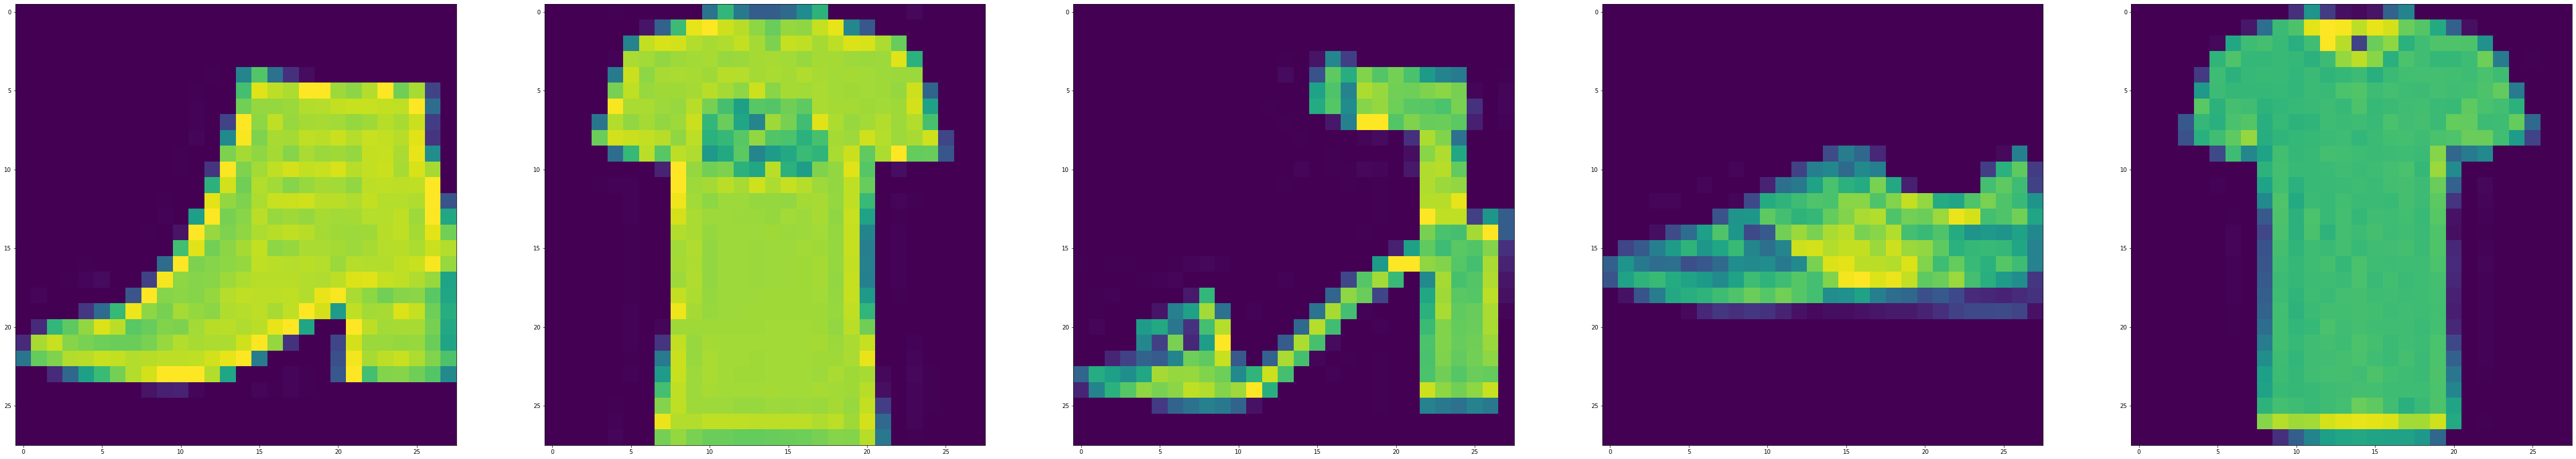

In [9]:
# 원본 이미지
from PIL import Image

f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

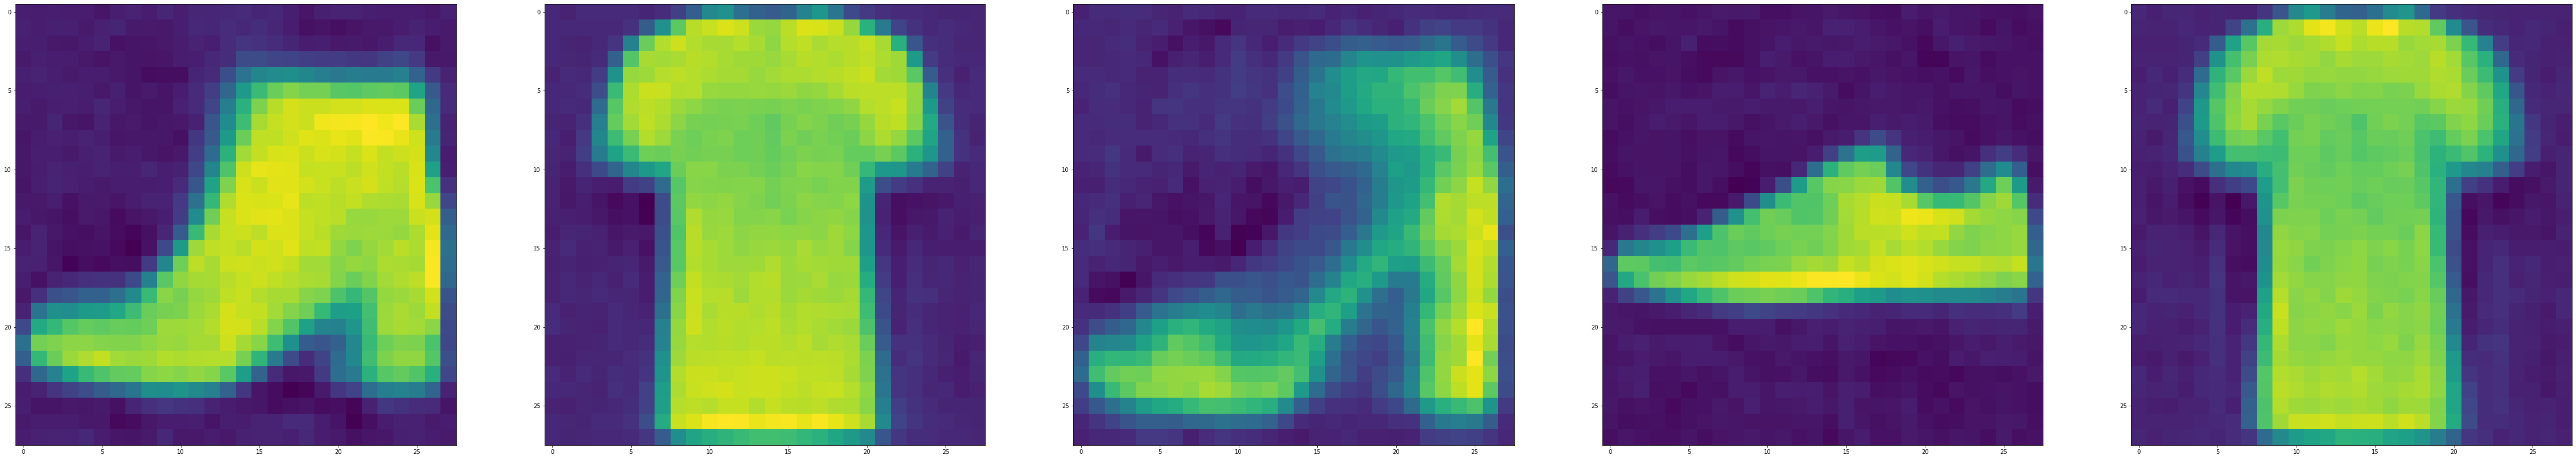

In [10]:
# 오토인코더로 예측한 이미지
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## 사용 사례 2: 이미지 노이즈 제거

### 1. Prepare dataset

In [11]:
# 입력 데이터 추출 및 입력/검증 데이터셋 생성
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

# 정규화
train_x = train_x/255
val_x = val_x/255

In [12]:
# 28*28 행렬로 변환
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

print('train_x의 크기 :', train_x.shape)
print('val_x의 크기 :', val_x.shape)

train_x의 크기 : (48000, 28, 28, 1)
val_x의 크기 : (12000, 28, 28, 1)


### 2. Add noise

In [13]:
# Salt and Pepper Noise 추가
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x*255)/255
val_x_n = seq_object.augment_images(val_x*255)/255

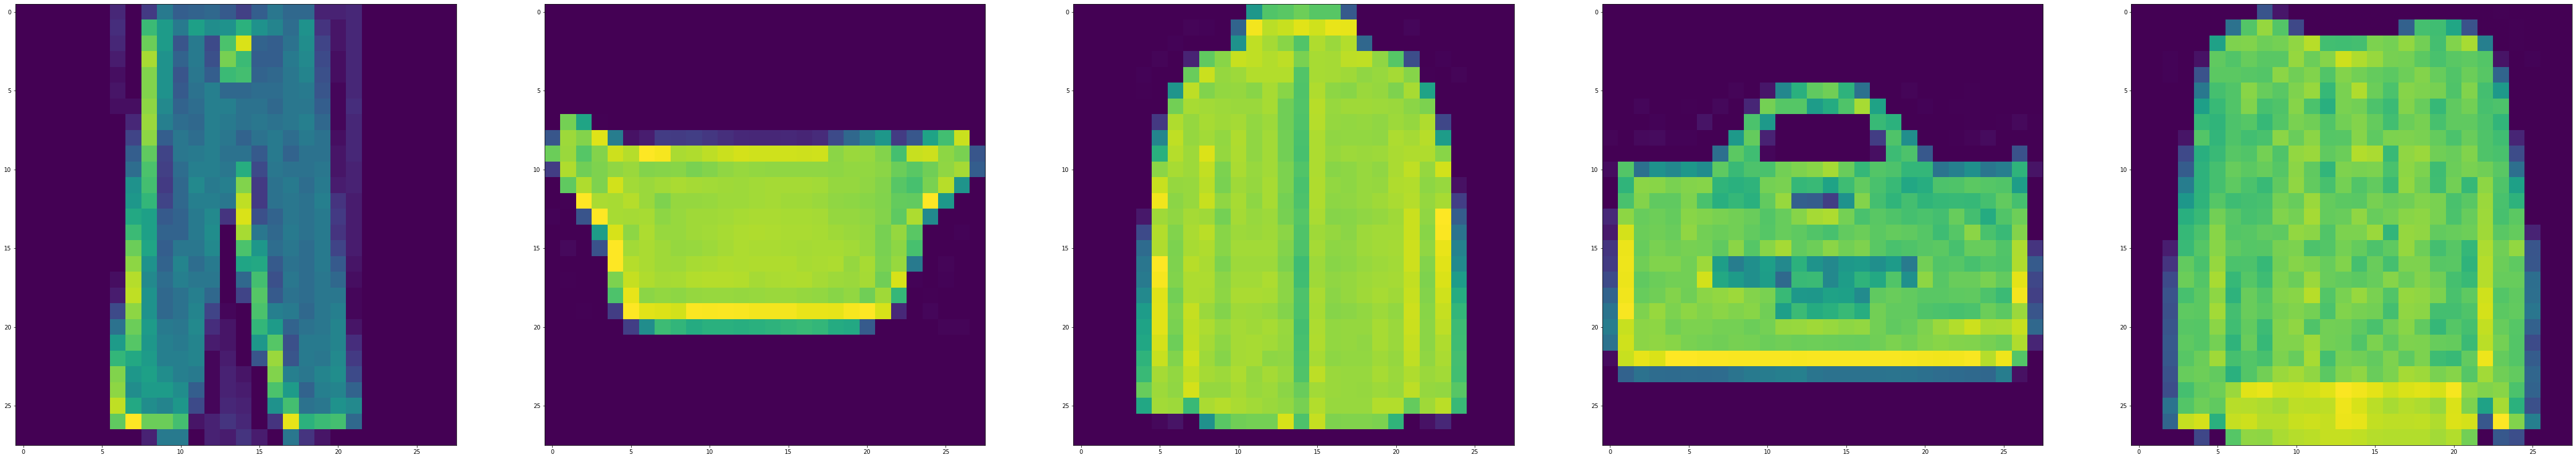

In [14]:
# 노이즈 추가하기 전
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

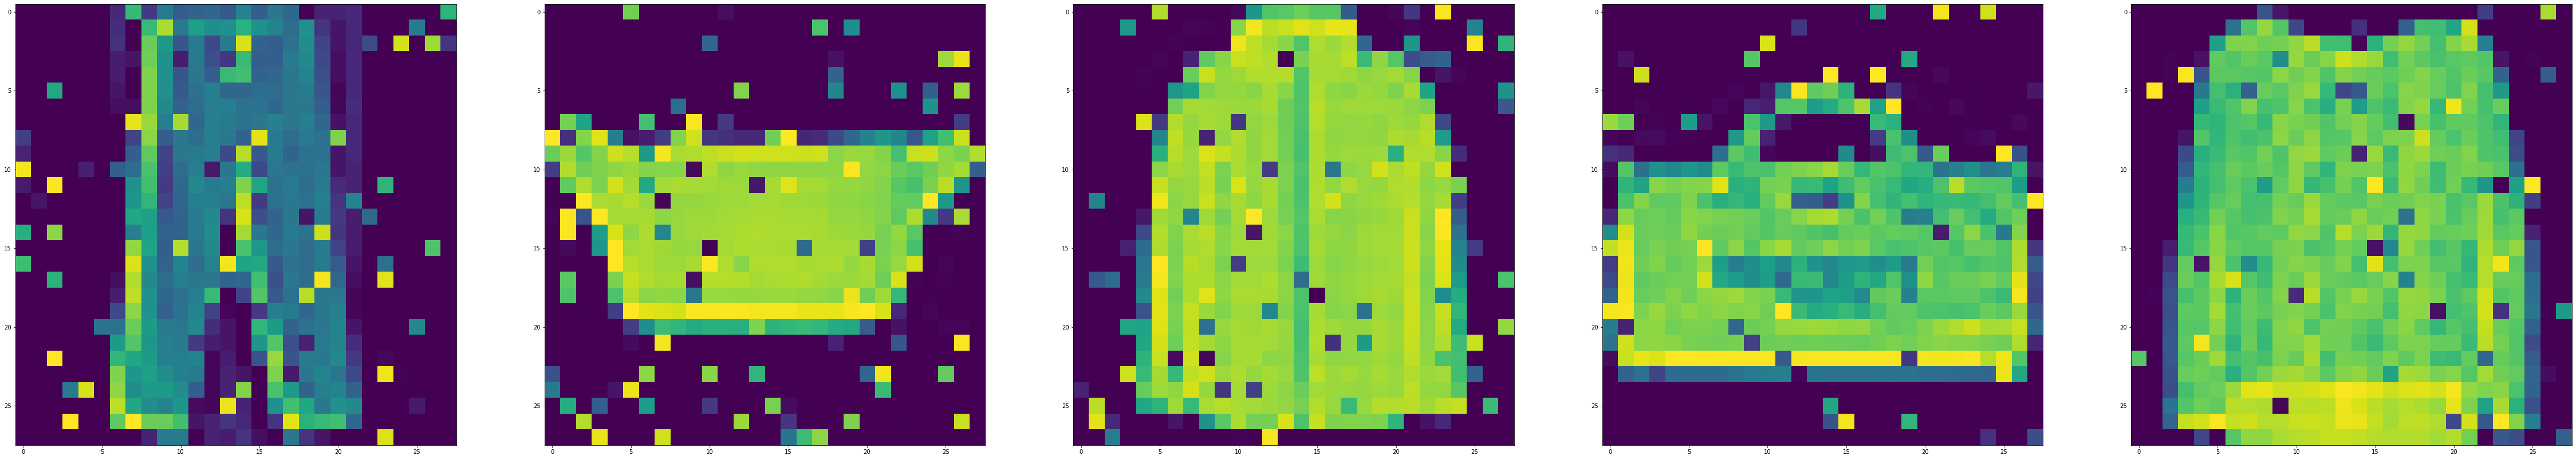

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

### 3. Autoencoder Modeling

In [16]:
############## 모델 정의 ##############
# 입력층
input_layer = Input(shape=(28, 28, 1))

# 인코더
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)

# 잠재 특징
latent_view = MaxPool2D((2, 2), padding='same')(encoded_layer3)

# 디코더
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)

# 출력층
output_layer = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
########################################

# 모델 컴파일
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [17]:
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)         

### 4. Train the model

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=20, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 61s 3s/step - loss: 0.0980 - val_loss: 0.0574
Epoch 2/20
24/24 [==============================] - 59s 2s/step - loss: 0.0462 - val_loss: 0.0386
Epoch 3/20
24/24 [==============================] - 59s 2s/step - loss: 0.0357 - val_loss: 0.0328
Epoch 4/20
24/24 [==============================] - 59s 2s/step - loss: 0.0306 - val_loss: 0.0284
Epoch 5/20
24/24 [==============================] - 60s 3s/step - loss: 0.0270 - val_loss: 0.0255
Epoch 6/20
24/24 [==============================] - 59s 2s/step - loss: 0.0247 - val_loss: 0.0236
Epoch 7/20
24/24 [==============================] - 61s 3s/step - loss: 0.0234 - val_loss: 0.0224
Epoch 8/20
24/24 [==============================] - 60s 2s/step - loss: 0.0221 - val_loss: 0.0216
Epoch 9/20
24/24 [==============================] - 60s 2s/step - loss: 0.0214 - val_loss: 0.0208
Epoch 10/20
24/24 [==============================] - 59s 2s/step - loss: 0.0209 - val_loss: 0.0208
Epoch 11/20
24/24 [

### 5. Predict

In [19]:
preds = model_2.predict(val_x_n[:10])

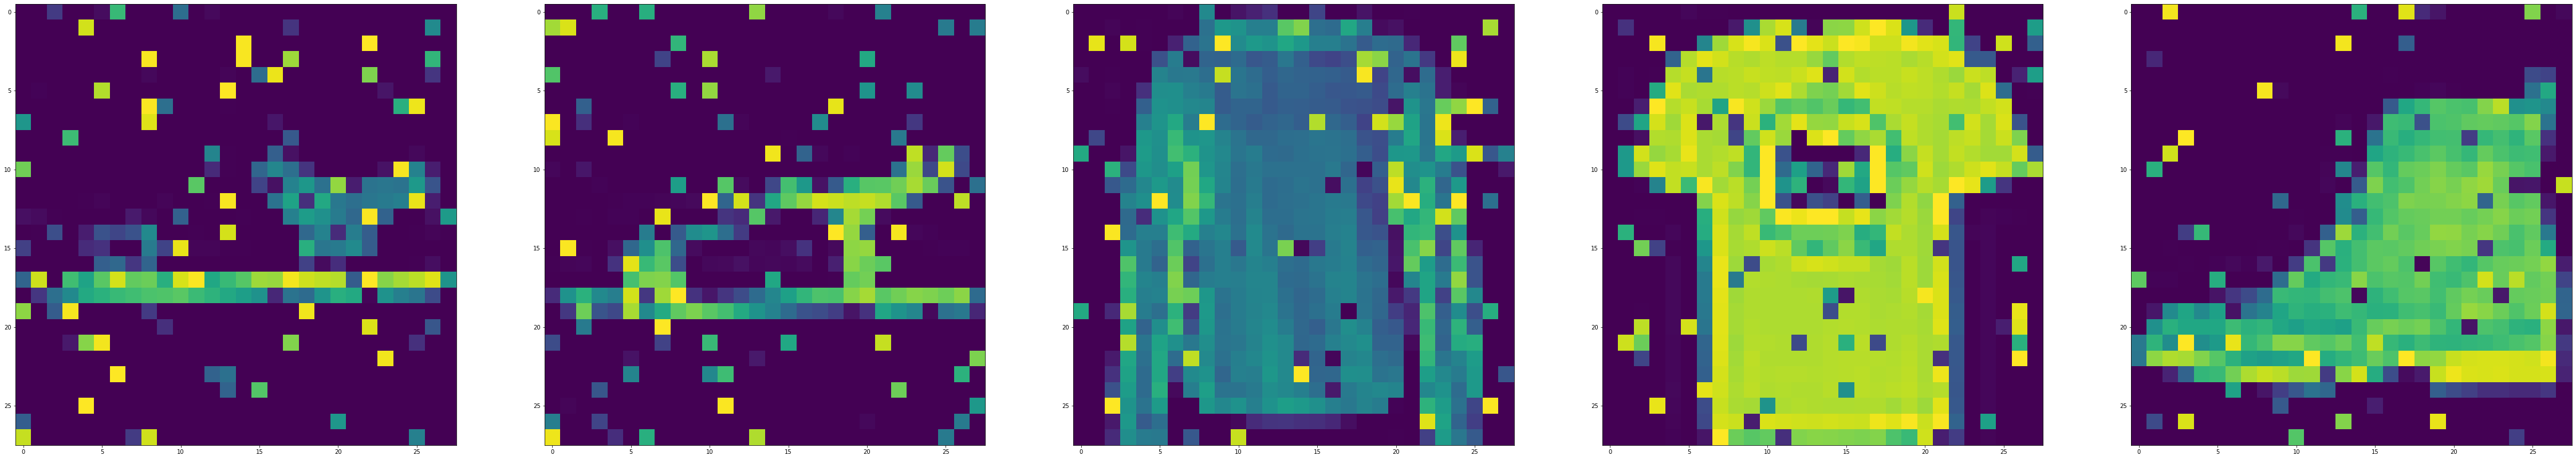

In [20]:
# 노이즈가 낀 검증 데이터
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(val_x_n[i].reshape(28, 28))
plt.show()

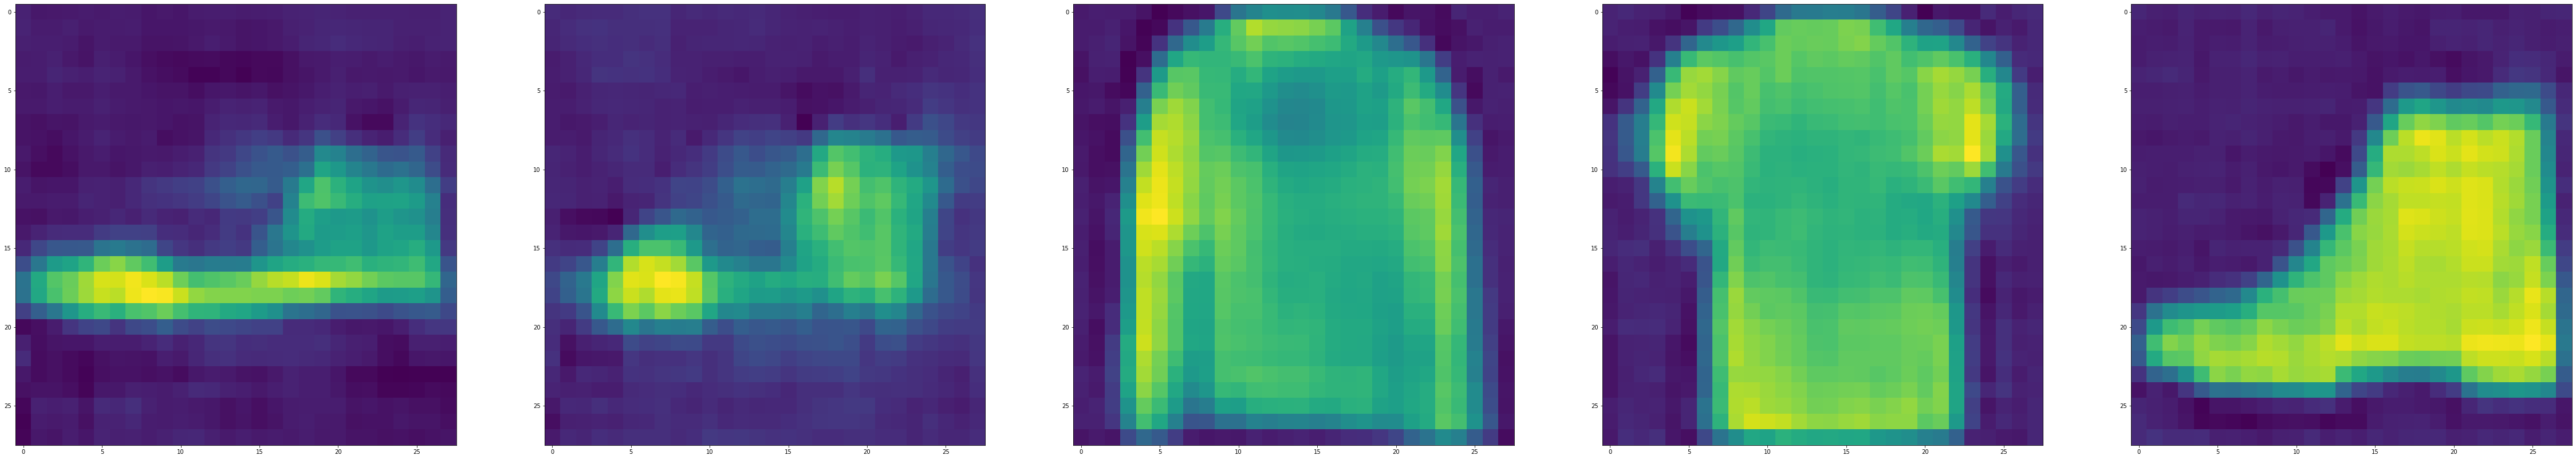

In [21]:
# 오토인코딩 후 검증 데이터
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

## 사용 사례 3: Seq2Seq 예측

### 1. Create dataset

In [22]:
# 임의의 숫자로 되어 있는 시퀀스 데이터 생성
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        # 임의의 숫자로 된 시퀀스 생성
        input_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        # 타겟 시퀀스 생성
        target = input_seq[:n_out]
        
        # 패딩된 시드 시퀀스 생성
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]
        
        # 카테고리형 변수로 변환
        X1.append(to_categorical([input_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
        
    # 불필요한 차원 제거
    X1 = np.squeeze(np.array(X1), axis=1)
    X2 = np.squeeze(np.array(X2), axis=1)
    y = np.squeeze(np.array(y), axis=1)
    
    return X1, X2, y

In [23]:
# 파라미터 설정
samples = 100000
features = 51
input_size = 6
output_size = 3

In [24]:
# 시퀀스 데이터 생성
inputs, seeds, outputs = dataset_preparation(input_size, output_size, features, samples)
print('데이터 크기 :', inputs.shape, seeds.shape, outputs.shape)
print('카테고리형으로 인코딩된 첫 번째 입력 시퀀스의 형태 :')
inputs[0][0]

데이터 크기 : (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
카테고리형으로 인코딩된 첫 번째 입력 시퀀스의 형태 :


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### 2. Autoencoder Modeling

In [25]:
def define_models(n_input, n_output):
    ############ 인코더 정의 ############
    # 입력: 시퀀스
    # 출력: 인코딩 상태
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    #####################################
    
    ############# 모델 정의 #############
    # 입력: 시드 시퀀스
    # 출력: 디코딩 상태, 디코딩 출력
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #####################################
    
    ############ 디코더 정의 ############
    # 입력: 현재 상태 + 인코딩 시퀀스
    # 출력: 디코딩 시퀀스
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    #####################################
    
    return model, encoder_model, decoder_model

In [26]:
# 오토인코더 모델 생성
autoencoder, encoder_model, decoder_model = define_models(features, features)

In [27]:
encoder_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 51)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [28]:
decoder_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 input_5[0][0]         

In [29]:
autoencoder.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 92160       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 lstm[0][1]            

### 3. Predict

In [30]:
# 원-핫 인코딩된 시퀀스를 디코딩
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [31]:
# 시퀀스 예측
def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)

    current_state = encoder.predict(sequence)
    for t in range(output_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

In [32]:
for k in range(5):
    X1, X2, y = dataset_preparation(input_size, output_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\nInput Sequence={}, SeedSequence={}, PredictedSequence={}'.format(reverse_onehot(X1[0]), 
                                                                             reverse_onehot(y[0]), 
                                                                             reverse_onehot(target)))


Input Sequence=[45, 34, 35, 35, 20, 42], SeedSequence=[35, 34, 45], PredictedSequence=[40, 40, 13]

Input Sequence=[31, 4, 20, 44, 21, 8], SeedSequence=[20, 4, 31], PredictedSequence=[39, 39, 39]

Input Sequence=[37, 4, 25, 28, 11, 32], SeedSequence=[25, 4, 37], PredictedSequence=[31, 28, 39]

Input Sequence=[21, 47, 22, 17, 42, 46], SeedSequence=[22, 47, 21], PredictedSequence=[46, 28, 28]

Input Sequence=[14, 43, 20, 33, 24, 4], SeedSequence=[20, 43, 14], PredictedSequence=[39, 39, 39]
